<span style="color:green">

# 3ª Implementação do Sistema de Recomendação

### Especificação: Context based
1 - pegar a descrição do filme (sinopse) numa base (imdb)<br>
2 - pegar os top 10 filmes que o usuario assistiu e usar pra criar um texto sobre o usuário<br>
3 - avaliar ranking: <br>
    - MAP (mean average precision) <br>
    - nDCG (normalized discounted cumulative gain) (pra todos os métodos)

### Desenvolvimento:
- 1ª parte: Levantamento dos dados
- 2ª parte: Texto para cada usuário, Recomendar e avaliar
- 3ª parte: Implementar um algoritmo híbrido com SVD
</span>

<br>
Arquivo movies2.csv pode ser obtido em github.com/xnes/recsys e executar a partir da 2ª parte

In [1]:
#Imports
import pandas as pd
import IPython.display as disp
import requests
import math
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy import spatial  #distancia: cosseno
from scipy.sparse import csc_matrix #matrix esparsa usada pros vetores
from scipy.sparse.linalg import svds
from numpy import dot,count_nonzero
from numpy.linalg import norm
from colorama import Fore, Back, Style       #prints coloridos e estilizados
import matplotlib.pyplot as plt     #plotar gráficos
from sklearn.metrics import average_precision_score, ndcg_score

def print_destaque(texto):
    print(Back.BLUE + Fore.LIGHTYELLOW_EX+ f' {texto} ')
    print(Style.RESET_ALL)

## 1ª parte: levantamento dos dados
1. Carregar a base de ratings dos usuários por filmes do MovieLens (https://files.grouplens.org/datasets/movielens/ml-25m.zip 2019-12-03 11:14	250M)
2. Carregar a base de sinopses
    - Do **Kaggle**, obtido 8547 sinopses: movie_synopsis.csv = https://www.kaggle.com/datasets/linggarmaretva/movie-synopsis-dataset/versions/1?resource=download
    - Demais sinopses obtidas por requisição de **TMDB** (www.themoviedb.org)
3. Tratar os títulos dos filmes da base para que sejam compatíveis com de bases de ratings
    - Título no formato: *The/A/An Object*, no lugar de: *Object, The (a.k.a. Objeto, O)* 
4. Unificar a base para ir para próxima parte
    - Usar o *ano de produção* do filme junto com o *título* para identificar sua sinopse

In [1]:
movies = pd.read_csv('movies.csv')           #obtido de MovieLens
sinopses = pd.read_csv('movie_synopsis.csv') #obtido de Kaggle e parece ser mesma sinopse que temos em TMDB.org
disp.display(movies.head(2))

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [2]:
disp.display(sinopses.head(3))                      #Checar dados do Kaggle
movies['titulo'] = movies['title'].str[:-7]         #retirar a informação de ano do filme campo 'title' para uma nova coluna chamada 'titulo'
movies['ano'] = movies['title'].str.extract("\((\d{4})\)", expand=True)     #criar uma coluna ano com o ano de produção do mesmo.
disp.display(movies.head(3))                        #Trabalharemos com as colunas 'titulo' e 'ano'

,title,synopsis
0,Four Rooms,It's Ted the Bellhop's first night on the job....
1,Judgment Night,"While racing to a boxing match, Frank, Mike, J..."
2,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...


,movieId,title,genres,titulo,ano
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995


In [3]:
print(f'Tenho a sinopse de {len(sinopses)} filmes')
print(f'Dos {len(movies)} filmes, tenho {len(set(movies.titulo)-set(sinopses.title))} sem sinopse')
n_duplicados = movies.duplicated(subset=['titulo']).value_counts()
print(f'{n_duplicados[False]} filmes com título único e {n_duplicados[True]} com nomes repetidos')
#print(*movies[movies.duplicated(subset=['titulo'])].sort_values('titulo')['titulo'].unique(), sep="; ") #listar todos os nomes que aparecem duplicados

Tenho a sinopse de 8457 filmes
Dos 62423 filmes, tenho 53199 sem sinopse
58513 filmes com título único e 3910 com nomes repetidos


In [4]:
movies[movies['titulo']=='Aladdin'] #Essa amostragem sugere que usar o nome e ano pode ser uma boa estratégia para identificar a sinopse correta de uma produção

,movieId,title,genres,titulo,ano
580,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,Aladdin,1992
22286,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy,Aladdin,1992
23734,119061,Aladdin (1986),Adventure|Fantasy,Aladdin,1986
59296,200540,Aladdin (2019),Adventure|Fantasy|Romance,Aladdin,2019


In [5]:
movies[movies['titulo']=='Misérables, Les']
#Idéia para implementatação futura: contar o generos dos filmes repetidos, e definir que o genero que acontece mais vezes é o prevalente, 
# logo todos os filmes com mesmo nome e mesmo gênero podem ser regravações e terem a mesmo sinopse

,movieId,title,genres,titulo,ano
72,73,"Misérables, Les (1995)",Drama|War,"Misérables, Les",1995
1784,1873,"Misérables, Les (1998)",Crime|Drama|Romance|War,"Misérables, Les",1998
13928,72117,"Misérables, Les (1935)",Drama|Romance,"Misérables, Les",1935
16981,89349,"Misérables, Les (1934)",Drama,"Misérables, Les",1934
19028,99149,"Misérables, Les (2012)",Drama|Musical|Romance|IMAX,"Misérables, Les",2012
19107,99560,"Misérables, Les (1958)",Drama,"Misérables, Les",1958
19108,99562,"Misérables, Les (1952)",Drama|Romance,"Misérables, Les",1952
20398,105509,"Misérables, Les (1978)",Drama,"Misérables, Les",1978


#### Tratar os títulos 
que terminam com artigo e passá-lo pro começo do título para comparar com demais bases

In [6]:
def mover_artigo_do_titulo(artigo):
    try:
        print(len(movies[movies['titulo'].str.endswith(', '+artigo)]),' filmes encontrados terminando com: \', ',artigo,'\'')
    except ValueError:
        print('Nenhum título de filme terminando com : ', artigo)
    movies.loc[movies['titulo'].str.endswith(', '+artigo), 'titulo'] = artigo +' '+movies[movies['titulo'].str.endswith(', '+artigo)]['titulo'].str[:-int(len(artigo)+2)]    
 #   movies.loc[movies['titulo'].str.contains(f',\s({artigo})\s\('), 'titulo'] = artigo +' '+ ###consertar os titulos aqui tb para começar a baixar via request mais json

artigos = ['A','As','O','Os','Le','Les','Lo','Los','Las','La','The','El','L\'', 'An']
for a in artigos:
    mover_artigo_do_titulo(a)

333  filmes encontrados terminando com: ',  A '
0  filmes encontrados terminando com: ',  As '
1  filmes encontrados terminando com: ',  O '
0  filmes encontrados terminando com: ',  Os '
12  filmes encontrados terminando com: ',  Le '
16  filmes encontrados terminando com: ',  Les '
0  filmes encontrados terminando com: ',  Lo '
3  filmes encontrados terminando com: ',  Los '
1  filmes encontrados terminando com: ',  Las '
26  filmes encontrados terminando com: ',  La '
3398  filmes encontrados terminando com: ',  The '
9  filmes encontrados terminando com: ',  El '
7  filmes encontrados terminando com: ',  L' '
41  filmes encontrados terminando com: ',  An '


Fazer uma função genérica que trabalha só com String e não necessita percorrer o dataset como a anterior

In [7]:
def set_artigo(titulo):
    artigos = ['A','As','O','Os','Le','Les','Lo','Los','Las','La','The','El','L\'', 'An', 'Il'] #Identificados artigos em inglês, português, espanhol, italiano, francês
    for art in artigos:
        if(titulo.endswith(', ' + art)):
            return art+' '+titulo[:-int(len(art)+2)]
    return titulo

alguns títulos tem um segundo nome (tipo: A.K.A.: Also Know As) ou o nome em um idioma original entre parenteses. Estes nomes todos poderão ser usados para identificação do filme

In [8]:
def get_parenteses(titulo):
    resposta = []
    for subtitulo in re.findall(r'\([^()]*\)', titulo): # encontrar substrings dentro dos parenteses
        x = subtitulo.strip('()')
        if x.startswith('a.k.a. '):
            x = x[7:]
        elif x.startswith('aka '):
            x = x[4:]
        resposta.append(x)
    for subtitulo in re.split(r'\([^()]*\)', titulo): # encontrar substrings fora dos parenteses
        resposta.append(subtitulo.strip())

    for i in range(len(resposta)):
        if ', ' in resposta[i]:
            resposta[i]= set_artigo(resposta[i])
    return list(filter(lambda s: s != '', resposta)) #remover da lista final os resultados vazios caso os tenha

Testar as duas funções acima:

In [9]:
get_parenteses('Twelve Monkeys (a.k.a. 12 Monkeys)')

['12 Monkeys', 'Twelve Monkeys']

In [10]:
set_artigo('Cité des enfants perdus, La')

'La Cité des enfants perdus'

In [11]:
movies[movies.index.isin([205,236,255,259,291,27345,29855,33562,34085,38949, 37254,])]

,movieId,title,genres,titulo,ano
205,207,"Walk in the Clouds, A (1995)",Drama|Romance,A Walk in the Clouds,1995
236,239,"Goofy Movie, A (1995)",Animation|Children|Comedy|Romance,A Goofy Movie,1995
255,258,"Kid in King Arthur's Court, A (1995)",Adventure|Children|Comedy|Fantasy|Romance,A Kid in King Arthur's Court,1995
259,262,"Little Princess, A (1995)",Children|Drama,A Little Princess,1995
291,295,"Pyromaniac's Love Story, A (1995)",Comedy|Romance,A Pyromaniac's Love Story,1995
27345,128910,"One-Way Trip to Antibes, A (2011)",Drama,A One-Way Trip to Antibes,2011
29855,134863,"Big Love Story, A (2012)",Comedy|Romance,A Big Love Story,2012
33562,143444,"Bigger Splash, A (2015)",Comedy|Crime|Drama|Mystery,A Bigger Splash,2015
34085,144622,"Ballerina's Tale, A (2015)",Documentary,A Ballerina's Tale,2015
37254,152230,"First, the Last, The (Les premiers les dernier...",(no genres listed),"First, the Last, The (Les premiers les derniers)",2016


In [12]:
a=0
b=0
c=0
for index, linha  in sinopses.iterrows():   #para cada linha do arquivo de sinopses
    nome_filme = (linha['title'])
    if (len(movies[movies['titulo']==nome_filme])==1):
        movies.loc[movies['titulo']==nome_filme,'sinopse'] = linha['synopsis']
        a+=1
        movies[movies['titulo']==nome_filme]
    elif (len(movies[movies['titulo']==nome_filme])==0):
        b+=1
    elif (len(movies[movies['titulo']==nome_filme])>1):
        c+=1
print(f'Achou {a} compativeis, {b} que tem sinopse e não estão na base e {c} que tem mais de uma refência (duplicados)')
movies

Achou 5332 compativeis, 1908 que tem sinopse e não estão na base e 1217 que tem mais de uma refência (duplicados)


,movieId,title,genres,titulo,ano,sinopse
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995,When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995,NaN
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...
62418,209157,We (2018),Drama,We,2018,NaN
62419,209159,Window of the Soul (2001),Documentary,Window of the Soul,2001,NaN
62420,209163,Bad Poems (2018),Comedy|Drama,Bad Poems,2018,NaN
62421,209169,A Girl Thing (2001),(no genres listed),A Girl Thing,2001,NaN


##### Premissas:
1. Filmes são identificados por Título e Ano de produção.
2. Filmes com mesmo nome feitos em anos distintos serão tratados como histórias diferentes sob a mesma titularidade, logo sumários diferentes 
2. Dois filmes do mesmo ano com mesmo nome devem ser o mesmo filme cadastrado duas vezes no banco de dados, deve ser falha no cadastro

In [13]:
import TMDB_key

def get_sumario(title = "Star Wars", year = 1977, prints=False):
    api_key = TMDB_key.api_key

    # Enviar uma solicitação GET à API do TMDb para pesquisar por filmes
    response = requests.get(f"https://api.themoviedb.org/3/search/movie?api_key={api_key}&query={title}&year={year}")
    
    if response.status_code == 200:     # se a solicitação foi bem-sucedida        
        data = response.json() # Carregar o conteúdo da resposta em um dicionário Python
        try:        
            result = data["results"][0] # Obter o primeiro resultado da pesquisa
        except IndexError:
            return float('NAN')
        if(prints):
            print(f"Título: {result['title']}")
            print(f"Sumário: {result['overview']}")
    else:
        print("Ocorreu um erro ao pesquisar por filmes. Response:",response.status_code)
        return

    return result['overview']

In [ ]:
def salvar_movies2():
    global movies2
    movies2.to_csv('movies2.csv', index=False)
    movies2 = pd.read_csv('movies2.csv')
    movies2.ano = movies2.ano.fillna(0).astype(int)
salvar_movies2()

As duas células subsequentes foram executadas várias vezes pois o servidor derrubava a conexão após algumas milhares de requisições. No final apenas 2.268 filmes ficaram sem sinopse, o que 3,6% da base total. Consideramos isso um sucesso na obtenção das informações para a próxima etapa

In [ ]:
movies2[movies2['sinopse'].isnull()] 

,movieId,title,genres,titulo,ano,sinopse
32,33,Wings of Courage (1995),Adventure|Romance|IMAX,Wings of Courage,1995,NaN
82,83,Once Upon a Time... When We Were Colored (1995),Drama|Romance,Once Upon a Time... When We Were Colored,1995,NaN
104,106,Nobody Loves Me (Keiner liebt mich) (1994),Comedy|Drama,Nobody Loves Me (Keiner liebt mich),1994,NaN
126,128,Jupiter's Wife (1994),Documentary,Jupiter's Wife,1994,NaN
181,183,Mute Witness (1994),Comedy|Horror|Thriller,Mute Witness,1994,NaN
...,...,...,...,...,...,...
62185,208199,Rufus (2013),Drama,Rufus,2013,NaN
62212,208279,"Mayflower, Quiltshoe & The Rubens Brothers (2017)",Children|Comedy,"Mayflower, Quiltshoe & The Rubens Brothers",2017,NaN
62305,208695,Vi på Saltkråkan (1968),Children,Vi på Saltkråkan,1968,NaN
62355,208859,Screen Play (1992),(no genres listed),Screen Play,1992,NaN


#### A célula abaixo foi executada várias vezes até preencher a base de dados. Ela normalmente termina a execução com erro por parte do servidor fechar a conexão.

In [ ]:
def scrape_TMDB():
    global movies2
    filmes_sem_sinopse = movies2[movies2['sinopse'].isnull()].sort_index(ascending=False).iterrows()
    c=0
    for index, filme in filmes_sem_sinopse:
        sumario = get_sumario(title=filme['titulo'], year=filme['ano']) # pegar sumario do filme com info básicas
        if(type(sumario) != str):                                       # recebeu um sumário com a requisição
            if('(' in filme['titulo']):                                 # verificar se tem () no título
                subtitulos = get_parenteses(filme['titulo'])            # testar requisição com subtitulos
                for subs in subtitulos:
                    sumario = get_sumario(title=subs, year=filme['ano'])
                    if(type(sumario) == str):
                        break
            elif (', ' in filme['titulo']):                             # verificar nome tá invertido
                sumario = get_sumario(title=set_artigo(filme['titulo']), year=filme['ano'])
        movies2.loc[(movies2.titulo==filme['titulo']) & (movies2.ano==filme['ano']),'sinopse'] = sumario    
        print(c,': ', filme['titulo'],': ', sumario)
        c+=1
        if(c%1000==0):
            movies2.to_csv('movies2.csv', index=False)

## 2ª parte: Recomendação por TF-IDF

Métodos *content-based* podem gerar recomendações de items e tags para usuários. Para isso, usaremos a razão a frequencia dos termos presentes nas sinopses dos filmes e sua presença do termos nos demais documentos que compõem o Corpus. Isso provê a especificidade dos termos. Essas frequencias podem ser representadas no formato TF-IDF:

$$ TF = \frac {\textrm{número de vezes que o termo aparece num documento} }{ \textrm{número total de termos no documento}} $$
$$ IDF = log (\frac {\textrm{número de documentos em toda base}} {\textrm{número de documentos na base que contém o termo}}) $$

O TF-IDF de um termo é calculado pela multiplicação dos scores acima
$$ \textit{TF-IDF} = TF * IDF $$

Neste trabalho, cada palavra do sumário do filme será um ítem. O conjunto dos termos do Corpus serão então as dimensões usadas no nosso sistema, cada termo representará uma direção e o score TF-IDF será o módulo. Assim a presença dos termos formam uma representação espacial do filme de acordo com seu sumário.

*fonte: Recommender System The Textbook, Aggarwal; Seção 11.4.4.3 Content-Based Methods e https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/*

In [2]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.drop('timestamp', axis=1)     #remover a coluna timestamp. Informação irrelevante
disp.display(ratings.head(3))
print(f'Temos na base principal {len(ratings.userId.unique())} usuários')

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0


Temos na base principal 162541 usuários


In [3]:
ratings = ratings.sort_values(by=['userId', 'rating'], ascending=False) #ordernar por rating em cada usuário para futuramente selecionar os ratings mais relevantes
disp.display(ratings.head(3))

,userId,movieId,rating
24999913,162541,29,5.0
24999914,162541,32,5.0
24999916,162541,50,5.0


Retirar dos ratings os filmes que não tem sinopse

In [4]:
sinopses = pd.read_csv('movies2.csv')
filmes_sem_sinopse = sinopses[sinopses['sinopse'].isnull()]['movieId'].tolist()
ratings = ratings[~ratings['movieId'].isin(filmes_sem_sinopse)]
ratings

,userId,movieId,rating
24999913,162541,29,5.0
24999914,162541,32,5.0
24999916,162541,50,5.0
24999923,162541,260,5.0
24999935,162541,541,5.0
...,...,...,...
53,1,7939,2.5
32,1,5684,2.0
45,1,7318,2.0
60,1,8685,1.0


In [5]:
usuarios = ratings.groupby('userId').apply(lambda x: x.iloc[:10]) #agrupar por usuários mantendo só as 10 primeiras linhas de cada
usuarios = usuarios.reset_index(level=0, drop=True)

In [6]:
usuarios.head()

,userId,movieId,rating
0,1,296,5.0
2,1,307,5.0
3,1,665,5.0
8,1,1237,5.0
18,1,2632,5.0


In [7]:
print(f'Selecionando apenas os 10 filmes mais relevantes de cada usuários, temos {len(usuarios.movieId.unique())} filmes a ser considerados apenas.')

Selecionando apenas os 10 filmes mais relevantes de cada usuários, temos 11473 filmes a ser considerados apenas.


Para otimização, removeremos todos os filmes que não foram apontados como favoritos pelos usuários

In [8]:
print(f'Selecionando apenas os 10 filmes mais relevantes de cada usuários, temos {len(usuarios.movieId.unique())} filmes a ser considerados apenas.')
sinopses = sinopses[sinopses['movieId'].isin(usuarios.movieId.unique())] #manter no DF Sinopses apenas os filmes que participam das preferencias dos usuários
sinopses = sinopses.reset_index(drop=True)
sinopses

Selecionando apenas os 10 filmes mais relevantes de cada usuários, temos 11473 filmes a ser considerados apenas.


,movieId,title,genres,titulo,ano,sinopse
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995,"Led by Woody, Andy's toys live happily in his ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji,1995,When siblings Judy and Peter discover an encha...
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men,1995,A family wedding reignites the ancient feud be...
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale,1995,"Cheated on, mistreated and stepped on, the wom..."
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II,1995,Just when George Banks has recovered from his ...
...,...,...,...,...,...,...
11468,207311,Last Christmas (2019),Comedy|Romance,Last Christmas,2019,Kate is a young woman who has a habit of makin...
11469,207834,Jenny Slate: Stage Fright (2019),Comedy|Documentary,Jenny Slate: Stage Fright,2019,Jenny Slate's first stand-up special is a mix ...
11470,207888,Black and Blue (2019),Action|Crime|Drama,Black and Blue,2019,A rookie cop inadvertently captures the murder...
11471,208006,Chhichhore (2019),Comedy|Romance,Chhichhore,2019,Following a group of friends from university a...


In [9]:
sinopses.sinopse

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
11468    Kate is a young woman who has a habit of makin...
11469    Jenny Slate's first stand-up special is a mix ...
11470    A rookie cop inadvertently captures the murder...
11471    Following a group of friends from university a...
11472    A flock of storks fly in the misty sky, all ca...
Name: sinopse, Length: 11473, dtype: object

### filmes_plano_vetor: matriz esparsa com score TFIDF das palavras
termos: vetor das palavras em todo o corpus

In [10]:
# Criar um objeto de transformação de TF-IDF
vetor_palavras = TfidfVectorizer(stop_words='english')

# Ajustar o objeto de transformação aos resumos de filmes
filmes_plano_vetor = vetor_palavras.fit_transform(sinopses.sinopse)

# Obter uma lista de todos os termos presentes nos resumos
termos = vetor_palavras.get_feature_names_out()
qtd_termos = len(termos)

def get_pos_termo(palavra: str):
    return np.where(termos == palavra)[0][0]

def get_filme(movieId:int, args=['titulo', 'ano']):
    return sinopses[sinopses['movieId']==movieId][args]

def get_filme_na_loc(posicao:int, args=['titulo', 'ano']):
    return sinopses.loc[posicao][args]

def get_filmes_usuario(id:int):
    return usuarios[usuarios.userId==id].merge(sinopses[['movieId','titulo', 'ano','sinopse']], left_on='movieId', right_on='movieId')

def get_tfidf_filme(movieId: int, log = False):
    try:
        posicao = sinopses[sinopses['movieId']== movieId].index[0]
    except IndexError:
        return "Filme não existe"
    titulo = sinopses.loc[posicao]['titulo']
    sinopse = sinopses.loc[posicao]['sinopse']
    if(log):
        print(titulo, '\n', sinopse)
    lista_termos = [termos[i] for i in filmes_plano_vetor.getrow(posicao).indices]
    lista_scores = filmes_plano_vetor.getrow(posicao).data
    return dict(zip(lista_termos, lista_scores))

In [11]:
get_tfidf_filme(1, True)

Toy Story 
 Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


{'differences': 0.14019373492990872,
 'aside': 0.14782652889791364,
 'learns': 0.10296474930398866,
 'eventually': 0.10690523833907116,
 'duo': 0.13110252314059437,
 'owner': 0.11071888154879786,
 'separate': 0.1372362656422659,
 'circumstances': 0.1306991283804184,
 'plots': 0.13895876472052046,
 'heart': 0.1055827772162221,
 'place': 0.1011071339651616,
 'losing': 0.1228428868004923,
 'afraid': 0.15854345019706192,
 'scene': 0.12257307133669613,
 'lightyear': 0.18841386493325182,
 'buzz': 0.47563035059118575,
 'brings': 0.11148192092885316,
 'birthday': 0.127730866631753,
 'room': 0.12178442692487747,
 'happily': 0.13514512151079375,
 'live': 0.0914628356303608,
 'toys': 0.16017398176152922,
 'andy': 0.4332705258336019,
 'woody': 0.4668851276006162,
 'led': 0.10899638247054329}

### O usuário
Nosso usuário é definido pelos termos dos top 10 filmes que ele mais gosta. Logo sua lista contém todos os termos de todos estes filme. Caso um termo apareça em mais de um filme, usaremos a função tangente hiperbólica da soma dos scores nos filmes que aparece. Essa função apresenta um limite positivo mínimo de zero e máximo de 1, o que serve para valorizar adequadamente quando tivermos a recorrência de termos com especifidade elevada nos filmes que o usuário gosta, respeitando os limites da natureza matemática do TF-IDF.
<center><img src="img/tangh.png" style="max-width: 30%"></center>

Para criar a lista de termos de usuário, usamos os termos que representam os top 90% da sua representatividade. Isso foi feito com base em herística uma vez que foi observado que as últimas  tinham um score muito baixo. Essa diminuição dos termos nos 10% menos relevantes eliminou cerca de 20% das palavras.

In [38]:
def criar_lista_termos_usuario(userId):
    dicionario = dict()
    lista_filmes = usuarios[usuarios['userId']==userId]['movieId'].to_numpy()
    for filme in lista_filmes:
        termos_filme = get_tfidf_filme(filme)
        for chave, valor in termos_filme.items():
            if chave in dicionario:                 #Se a palavra já existe no texto do usuário
                dicionario[chave] = math.tanh(dicionario[chave]+valor) #Ela ganha um score mais alto usando tangente hiperbólica (max=1)
            else:
                dicionario[chave] = valor
    lista_usuario = sorted(dicionario.items(), key=lambda kv: kv[1],reverse=True)

    #dispensar os termos de menor valor que somam 10% para ficar com os mais representativos
    dez_porcento = sum(dicionario.values()) * 0.1
    while (dez_porcento > 0):
        dez_porcento -= lista_usuario.pop()[1]
    return lista_usuario

def criar_texto_usuario(lista_termos: list):
    texto = str()
    for tupla in lista_termos:
        texto += tupla[0] + ' '
    return texto

def criar_vetor_usuario(lista_termos=None, userId=0):
    if(userId != 0):
        lista_termos = criar_lista_termos_usuario(userId)
    vetor = np.array([np.zeros(qtd_termos)])[0]
    for chave, valor in lista_termos:
        vetor[get_pos_termo(chave)] = valor
    return csc_matrix(vetor)   

def comparar_vetores_esparsos(a:csc_matrix, b:csc_matrix):
    a, b = a.toarray()[0], b.toarray()[0]
    return 1 - spatial.distance.cosine(a, b)

def get_mais_similares(vetor):
    lista_similaridades = []
    lista_movieIds = sinopses['movieId'].to_list()
    lista_linhas_zeradas = []
    for linha in range(filmes_plano_vetor.shape[0]): #percorrer cada linha com filmes no vetor 
        linha_vetor = filmes_plano_vetor.getrow(linha)#.toarray()[0]
        cos_sim = 1 - spatial.distance.cosine(vetor.toarray()[0], linha_vetor.toarray()[0])
        if(cos_sim > 0):
            lista_similaridades.append(cos_sim)
        else:
            lista_linhas_zeradas.append(linha)
    for linha in sorted(lista_linhas_zeradas, reverse=True):
        lista_movieIds.pop(linha)

    ordenados = list(zip(*sorted(zip(lista_similaridades, lista_movieIds), key=lambda x: x[0], reverse=True) ))
    return ordenados

Nota-se que as similiridade vem pela especificidade dos termos na sinopse, o que muito vezes pode estar fora do contexto. Um exemplo foi feito criando um vetor com os termos 'star' e 'wars'. Espera-se que se destaque os filmes da saga Star Wars, mas entre os resultados temos referencia a palavra 'star' dentro de contexto 'movie star' e 'pop star' que acavam se destacando mais que a combinação 'star' + 'wars'. Apenas 4 dos 10 filmes em destaque é de fato relacionado a 'Star Wars'

In [40]:
termos_star_wars = {'star': 1.0, 'wars':1.0}.items()
usuario_star_wars = criar_vetor_usuario(termos_star_wars)
scores_similares_star_wars,filmes_similares_star_wars = get_mais_similares(usuario_star_wars)
for i in range(10):
    print(sinopses[sinopses['movieId']==filmes_similares_star_wars[i]][['titulo','sinopse']].to_string())

      titulo                                                                                                                                                                                           sinopse
10607    Fan  A man who bears a striking resemblance to a renowned movie star becomes an obsessive fan, but when his fierce love is spurned by the star, he decides to destroy the star's life and reputation.
                                                      titulo                                                                                                             sinopse
8345  Empire of Dreams: The Story of the 'Star Wars' Trilogy  From the earliest versions of the script to the blockbuster debuts, explore the creation of the Star Wars Trilogy.
                         titulo                                                                                                                                                                                                         

(tempo de execução: 4.5s)

In [39]:
def recomendar_filmes(usuario:int):
    filmes_vistos_pelo_usuario = get_filmes_usuario(usuario)['movieId'].to_list()
    termos_usuario = criar_lista_termos_usuario(usuario)
    vetor_usuario = criar_vetor_usuario(termos_usuario)
    similaridades, filmes_similares = get_mais_similares(vetor_usuario)
    print_destaque("Filmes do usuário "+str(usuario))
    display(get_filmes_usuario(usuario))
    print_destaque("Texto do usuário "+str(usuario)+" contém "+str(len(termos_usuario))+" palavras")
    print(criar_texto_usuario(termos_usuario)[:600],"...")
    recomendacoes = [filme for filme in filmes_similares if filme not in set(filmes_vistos_pelo_usuario)]
    print()
    print_destaque(f"Recomendados 20 dos {len(recomendacoes)} filmes analisados com alguma similaridade.")    
    display(sinopses[sinopses['movieId'].isin(recomendacoes[:20])][['movieId','titulo', 'ano', 'sinopse']])
    
recomendar_filmes(1)

 Filmes do usuário 1 



,userId,movieId,rating,titulo,ano,sinopse
0,1,296,5.0,Pulp Fiction,1994,"A burger-loving hit man, his philosophical par..."
1,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu),1993,Julie is haunted by her grief after living thr...
2,1,665,5.0,Underground,1995,Black marketeers Marko and Blacky manufacture ...
3,1,1237,5.0,"Seventh Seal, The (Sjunde inseglet, Det)",1957,When disillusioned Swedish knight Antonius Blo...
4,1,2632,5.0,"Saragossa Manuscript, The (Rekopis znaleziony ...",1965,"In the Napoleonic wars, an officer finds an ol..."
5,1,2692,5.0,Run Lola Run (Lola rennt),1998,Lola receives a phone call from her boyfriend ...
6,1,3569,5.0,"Idiots, The (Idioterne)",1998,With his first Dogma-95 film director Lars von...
7,1,3949,5.0,Requiem for a Dream,2000,The hopes and dreams of four ambitious people ...
8,1,4144,5.0,In the Mood For Love (Fa yeung nin wa),2000,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo..."
9,1,4325,5.0,"Night, The (Notte, La)",1960,"1943. The affair between Anna, unhappily marri..."


 Texto do usuário 1 contém 239 palavras 

marko manni pino lola franco blacky addictions inner overcomes drug spiraling block stories quemada venta ranks film addiction death shattered gallows su chow people ingeniously unfurl zhen ambitious moll communist polite formal mo addled wan apartments spouses li dogma caper burger mind meets withdraw trier hopes sprawling philosophical forth redemptive jof antonius washed converge neighboring body platform 95 lars alternatives dm depending eventually wakes styles 1962 control comedic look idiots lock black begin olivier interactions tells story dreams bustling suppress intertwining ferrara f ...

 Recomendados 20 dos 8973 filmes analisados com alguma similaridade. 



,movieId,titulo,ano,sinopse
1517,1701,Deconstructing Harry,1997,This film tells the story of a successful writ...
2871,3328,Ghost Dog: The Way of the Samurai,1999,An African-American Mafia hit man who models h...
3129,3678,The Man with the Golden Arm,1955,A junkie must face his true self to kick his d...
3192,3747,Jesus' Son,1999,A young man turns from drug addiction and pett...
4674,6032,A Little Romance,1979,A young American girl and a young French boy m...
4888,6436,This Boy's Life,1993,When a son and mother move to Seattle in hopes...
5933,8930,"Five Obstructions, The (Fem benspænd, De)",2003,"Lars von Trier challenges his mentor, filmmake..."
6287,27523,My Sassy Girl (Yeopgijeogin geunyeo),2001,"A dweeby, mild-mannered man comes to the aid o..."
6305,27674,11:14,2003,Tells the seemingly random yet vitally connect...
6764,40574,Get Rich or Die Tryin',2005,A tale of an inner city drug dealer who turns ...


A função abaixo levou 174 minutos para calcular uma população de 2000 usuarios. Média de 5,2 segundos/usuário.
<br>(tempo de execução: 174m 21.2s)

In [14]:
def calcular_map(qt_usuarios = 2000):
    # |     | filme1| filme2| filme3| filme4| filme5| filme6
    # |user1|
    # |user2|
    # |user3|
    colunas_matriz_true = sinopses['movieId'].to_numpy()
    linhas_matriz_true = usuarios['userId'].unique()[:(qt_usuarios)]
    matriz_true_bin = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_true_real = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_score = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_assistidos = np.zeros(qt_usuarios)
    linha = 0
    for user in linhas_matriz_true:
        for filme, nota in ratings[ratings['userId']==user][['movieId','rating']].to_numpy():
            posicao_filme = np.where(colunas_matriz_true==filme)
            matriz_true_bin[linha][posicao_filme] = 1
            matriz_true_real[linha][posicao_filme] = nota
            matriz_assistidos[linha] += 1
        coluna = 0
        vetor_user = criar_vetor_usuario(userId=user)
        for filme in colunas_matriz_true:
            matriz_score[linha][coluna] = 1 - spatial.distance.cosine(filmes_plano_vetor.getrow(coluna).toarray()[0], vetor_user.toarray()[0])
            coluna += 1
        linha += 1
    metrica_map = []
    for linha in range(len(linhas_matriz_true)):
        metrica_map.append(average_precision_score(matriz_true_bin[linha], matriz_score[linha]))

    return matriz_true_bin, matriz_score, metrica_map, matriz_assistidos, matriz_true_real

matriz_true_bin, matriz_score, metrica_map, matriz_assistidos, matriz_true_real = calcular_map()

Ao usar MAP para métrica, obteve-se maiores valores quando o usuário tinha menores filmes com rating. Em geral, usuários com pouco mais de 20 notas (o valor mínimo) o valor de MAP se aproximava de 0,5.

In [46]:
def medir_resultados(metrica_map, matriz_score, matriz_true_real, matriz_assistidos):
    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(2)
    figure.tight_layout(pad=2)
    
    # Gráfico 1
    axis[0].plot(metrica_map)
    axis[0].set_title("Métrica MAP (Mean Average Precision) por usuário")
    
    # Gráfico 2
    axis[1].bar(range(len(matriz_assistidos)), matriz_assistidos)
    axis[1].grid(color='green', linestyle='--', linewidth=0.7, axis='y', alpha=0.7)
    axis[1].set_title('Volume de notas dadas pelos usuários')
    axis[1].set_xlabel('Usuários')
    axis[1].set_ylabel('# filmes com nota')
    axis[1].axhline(100, color='green', linestyle='--', linewidth=0.7)
    plt.show()


    ndcg = ndcg_score(matriz_true_real,matriz_score, k=None, ignore_ties=True)
    print_destaque("NDCG Score: "+str(ndcg))

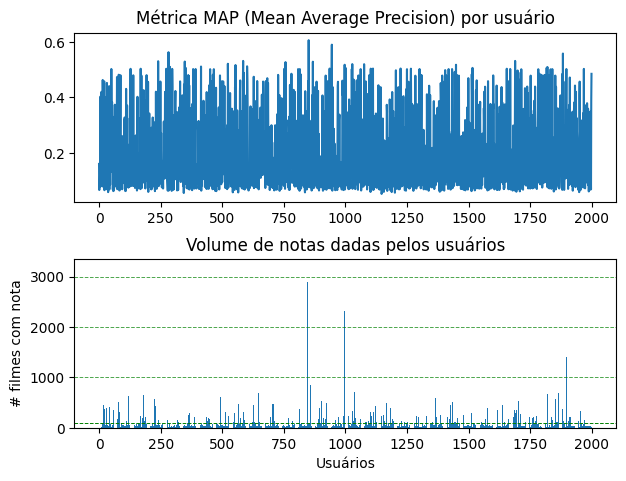

 NDCG Score: 0.6597976432113756 



In [48]:
medir_resultados(metrica_map, matriz_score, matriz_true_real, matriz_assistidos)

## 3ª parte: Recomendação Híbrida: TFIDF + SVD

A implementação anterior utiliza de uma matriz esparsa e posteriormente o cálculo de cosseno para obter a similaridade entre os elementos que compõe a matriz: Filme e os Termos que compoem o Corpus 
<br>
Sabemos que SVD é um método da algebra linear que remove a esparsidade da matriz preenchedo-a com valores derivados da relação entre os elementos e eliminando a necessidade do cálculo de cosseno.
<br>
(tempo de execução: 2.7s)

In [19]:
from scipy.sparse.linalg import svds
from numpy import count_nonzero
U, sigma, Vt = svds(filmes_plano_vetor, k = 10) 

print(f"Matriz original{filmes_plano_vetor.shape} decomposta em U{U.shape}, sigma {sigma.shape} e Vt{Vt.shape}.")

sigma_matriz_diagonal=np.diag(sigma) #sigma é um array contendo a diagonal
matriz_filme_termo_predita = np.dot(np.dot(U, sigma_matriz_diagonal), Vt)
matriz_SVD = pd.DataFrame(matriz_filme_termo_predita, columns = termos, index=sinopses['movieId'])

esparsidade_SVD = 1.0 - ( count_nonzero(matriz_SVD) / float(matriz_SVD.size) )
print("Esparsidade: ", esparsidade_SVD,"%")

matriz_SVD.head()

Matriz original(11473, 32233) decomposta em U(11473, 10), sigma (10,) e Vt(10, 32233).
Esparsidade:  0.0 %


,00,000,006,007,05pm,10,100,1000,101,103,...,émile,état,étienne,íris,čížek,čížeks,łódź,žižek,τwo,テレパシー能力者
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000047,0.000782,0.000006,0.000082,0.000016,0.000503,0.000270,0.000024,0.000026,0.000022,...,0.000025,0.000020,0.000015,0.000002,0.000005,0.000002,0.000027,0.000024,0.000003,0.000015
2,0.000260,0.002654,0.000076,0.000386,-0.000004,0.001901,0.000562,0.000065,0.000148,0.000019,...,0.000068,0.000075,0.000030,0.000049,0.000111,0.000055,-0.000005,0.000036,0.000057,0.000057
3,0.000022,0.000493,-0.000010,0.000046,0.000027,0.000286,0.000115,0.000106,-0.000097,0.000040,...,0.000020,-0.000022,0.000013,-0.000032,0.000023,0.000012,0.000041,-0.000005,-0.000034,-0.000014
4,0.000047,0.000933,0.000010,0.000084,0.000013,0.000443,0.000313,-0.000011,0.000091,0.000016,...,0.000013,-0.000009,0.000026,0.000013,0.000074,0.000037,-0.000013,0.000006,0.000006,0.000002
5,-0.000005,0.001626,-0.000008,0.000184,0.000057,0.001759,0.000424,0.000114,0.000036,0.000072,...,0.000066,0.000022,-0.000029,-0.000027,0.000046,0.000023,0.000003,-0.000031,-0.000068,-0.000045


Ao analisarmos a sinopse do filme **Toy Story** podemos verificar que usando TFIDF os termos que se destacam são *buzz*, *andy* e *woody*, os protagonistas do filme. Já usando SVD essa relação muda totalmente e termos relacionados ao contexto do filme mas fora da sinopse começam a se destacar.

In [21]:
print(sinopses[sinopses['movieId']==1]['sinopse'][0])
get_tfidf_filme(1)

Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


{'differences': 0.14019373492990872,
 'aside': 0.14782652889791364,
 'learns': 0.10296474930398866,
 'eventually': 0.10690523833907116,
 'duo': 0.13110252314059437,
 'owner': 0.11071888154879786,
 'separate': 0.1372362656422659,
 'circumstances': 0.1306991283804184,
 'plots': 0.13895876472052046,
 'heart': 0.1055827772162221,
 'place': 0.1011071339651616,
 'losing': 0.1228428868004923,
 'afraid': 0.15854345019706192,
 'scene': 0.12257307133669613,
 'lightyear': 0.18841386493325182,
 'buzz': 0.47563035059118575,
 'brings': 0.11148192092885316,
 'birthday': 0.127730866631753,
 'room': 0.12178442692487747,
 'happily': 0.13514512151079375,
 'live': 0.0914628356303608,
 'toys': 0.16017398176152922,
 'andy': 0.4332705258336019,
 'woody': 0.4668851276006162,
 'led': 0.10899638247054329}

In [24]:
def get_SVD_termos_filme(movieId: int):
    return matriz_SVD[matriz_SVD.index==movieId].T.sort_values(by=movieId, ascending=False).rename(columns={movieId: 'score'})

get_SVD_termos_filme(1)[:15]

movieId,score
life,0.009814
love,0.007211
film,0.006975
story,0.006843
new,0.006811
wife,0.005732
family,0.005301
time,0.005270
friends,0.005232
town,0.005006


Foi mantido a eliminação dos 10% dos termos menos relevantes, neste caso eliminou perto da metade dos ítems.

In [27]:
def criar_SVD_lista_termos_usuario(userId: int, top_k = 10):
    dicionario = dict()
    lista_filmes = usuarios[usuarios['userId']==userId]['movieId'].to_numpy()
    for filme in lista_filmes:
        termos_filme = get_SVD_termos_filme(filme)[:top_k].to_dict()['score']
        for chave, valor in termos_filme.items():
            if chave in dicionario:                 #Se a palavra já existe no texto do usuário
                dicionario[chave] = math.tanh(dicionario[chave]+valor) #Ela ganha um score mais alto usando tangente hiperbólica (max=1)
            else:
                dicionario[chave] = valor
    lista_usuario = sorted(dicionario.items(), key=lambda kv: kv[1],reverse=True)

    #dispensar os termos de menor valor que somam 10% para ficar com os mais representativos
    dez_porcento = sum(dicionario.values()) * 0.1
    while (dez_porcento > 0):
        dez_porcento -= lista_usuario.pop()[1]
    return lista_usuario

criar_SVD_lista_termos_usuario(1)

[('life', 0.2628294881927777),
 ('love', 0.18704540769160383),
 ('man', 0.16635027349218015),
 ('story', 0.1360258303764689),
 ('woman', 0.1097747497167753),
 ('world', 0.08951154376888233),
 ('film', 0.08852327588621663),
 ('old', 0.08723619433543356),
 ('young', 0.081724913659423),
 ('family', 0.07321920596429186),
 ('wife', 0.07002069970068499),
 ('year', 0.06402021006910463),
 ('war', 0.06055176667433892),
 ('new', 0.05054937357971161),
 ('father', 0.038021069424647926),
 ('mother', 0.03163643992442993),
 ('son', 0.031258898369485456),
 ('school', 0.02838660010330205),
 ('police', 0.026528411391529942),
 ('daughter', 0.025121553644321334),
 ('time', 0.025091072388427848),
 ('home', 0.024775148041794728),
 ('girl', 0.022428863490053325)]

A recomendação do filme foi feita com base no texto do usuário e o score das palavras.<br>
Este score aponta para os filmes mais relevantes que são multiplicados pelo valor obtido na matriz SVD reconstruída, a relação eram somados caso apresentassem recorrência nos demais termos. Exemplo:
- Termos do usuário: {'star': 2, 'wars': 1}
- Filmes mais semelhantes ao termo 'star': {'Star Wars': 0.3, 'Force Awakens': 0.2}
- Filmes mais semelhantes ao termo 'wars': {'Star Wars': 0.1, 'World War 2': 0.1}
- Ranking dos filmes: 'Star Wars': 0.7, 'Force Awakens': 0.4, 'World War 2': 0.1}

(tempo de execução: 0.6 segundos)


In [43]:
def recomendar_filmes_SVD(usuario:int, k = 20, max_resultados=20):
    resultado = dict()
    lista_usuario = criar_SVD_lista_termos_usuario(usuario)
    print_destaque("Filmes do usuário "+str(usuario))
    display(get_filmes_usuario(usuario))
    print_destaque("Texto do usuário "+str(usuario)+" contém "+str(len(lista_usuario))+" palavras")
    print(criar_texto_usuario(lista_usuario))
    for termo, score in lista_usuario:
        lista_filmes_termo = matriz_SVD.T[matriz_SVD.T.index==termo].T.sort_values(by=termo, ascending=False)[:k][termo]
        for filme, rating in lista_filmes_termo.to_dict().items():
            if filme in resultado:
                resultado[filme] = resultado[filme] + rating
            else:
                resultado[filme] = rating
    resultado = sorted(resultado.items(), key=lambda kv: kv[1],reverse=True)
    resultado = pd.DataFrame(columns=["movieId", "score"], data=resultado ) 
    resultado = pd.merge(resultado, sinopses)[["movieId", "score", "titulo", "ano", "sinopse"]][:max_resultados]       
    return resultado

        
recomendar_filmes_SVD(1)

 Filmes do usuário 1 



,userId,movieId,rating,titulo,ano,sinopse
0,1,296,5.0,Pulp Fiction,1994,"A burger-loving hit man, his philosophical par..."
1,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu),1993,Julie is haunted by her grief after living thr...
2,1,665,5.0,Underground,1995,Black marketeers Marko and Blacky manufacture ...
3,1,1237,5.0,"Seventh Seal, The (Sjunde inseglet, Det)",1957,When disillusioned Swedish knight Antonius Blo...
4,1,2632,5.0,"Saragossa Manuscript, The (Rekopis znaleziony ...",1965,"In the Napoleonic wars, an officer finds an ol..."
5,1,2692,5.0,Run Lola Run (Lola rennt),1998,Lola receives a phone call from her boyfriend ...
6,1,3569,5.0,"Idiots, The (Idioterne)",1998,With his first Dogma-95 film director Lars von...
7,1,3949,5.0,Requiem for a Dream,2000,The hopes and dreams of four ambitious people ...
8,1,4144,5.0,In the Mood For Love (Fa yeung nin wa),2000,"Hong Kong, 1962: Chow Mo-Wan and Su Li-Zhen mo..."
9,1,4325,5.0,"Night, The (Notte, La)",1960,"1943. The affair between Anna, unhappily marri..."


 Texto do usuário 1 contém 23 palavras 

life love man story woman world film old young family wife year war new father mother son school police daughter time home girl 


,movieId,score,titulo,ano,sinopse
0,73713,0.953844,"Butterfly, The (Papillon, Le)",2002,"An old man who has one interest in life, colle..."
1,27163,0.848634,Something Is Happening (Kuch Kuch Hota Hai),1998,"Per her mother's last wish, an 8 year old girl..."
2,135504,0.805012,Little Boy,2015,An eight-year-old boy is willing to do whateve...
3,118814,0.742341,Playing It Cool,2014,A young man meets and instantly falls in love ...
4,4885,0.699131,Domestic Disturbance,2001,A divorced father discovers that his 12-year-o...
5,6032,0.673073,A Little Romance,1979,A young American girl and a young French boy m...
6,412,0.653989,The Age of Innocence,1993,"In 19th century New York high society, a young..."
7,91537,0.645956,"Don't Worry, I'm Fine (Je vais bien, ne t'en f...",2006,A 19-year-old searches for her twin brother af...
8,8659,0.596822,Brief Crossing (Brève traversée),2001,A young French man and an older English woman ...
9,1159,0.579895,Love in Bloom,1935,A young girl runs away from her carnival famil...


Aqui para calcular os resultados foi mais simples, uma vez que a matriz SVD já contém valores que são usados de similaridade. Foi usada da mesma forma que para o cálculo da recomendação uma soma dos valores dos filmes indicados pelos termos do usuário multiplicado pelo score do termo no texto do usuário. Como a matriz SVD já contém todos os valores, o tempo de execução é de aproximadamente entre 0.4 e 0.66 segundos/usuário.  (tempo de execução: 32.8s)

In [50]:
def calcular_map_SVD(qt_usuarios = 100):

    colunas_matriz_true = sinopses['movieId'].to_numpy()
    linhas_matriz_true = usuarios['userId'].unique()[:(qt_usuarios)]
    matriz_true_bin = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_true_real = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_score = np.zeros((len(linhas_matriz_true), len(colunas_matriz_true)))
    matriz_assistidos = np.zeros(qt_usuarios)
    linha = 0
    for user in linhas_matriz_true:
        for filme, nota in ratings[ratings['userId']==user][['movieId','rating']].to_numpy():
            posicao_filme = np.where(colunas_matriz_true==filme)
            matriz_true_bin[linha][posicao_filme] = 1
            matriz_true_real[linha][posicao_filme] = nota
            matriz_assistidos[linha] += 1
        coluna = 0
        lista_termos_usuario = criar_SVD_lista_termos_usuario(user)
        
        for termo, score in lista_termos_usuario:
            matriz_score[linha] += matriz_SVD.T[matriz_SVD.T.index==termo].to_numpy()[0]*score
        linha += 1
    metrica_map = []
    for linha in range(len(linhas_matriz_true)):
        metrica_map.append(average_precision_score(matriz_true_bin[linha], matriz_score[linha]))

    return matriz_true_bin, matriz_score, metrica_map, matriz_assistidos, matriz_true_real

matriz_true_SVD_bin, matriz_SVD_score, metrica_SVD_map, matriz_assistidos, matriz_true_SVD_real = calcular_map_SVD()

Observamos também que MAP melhora com a quantidade de notas dadas.

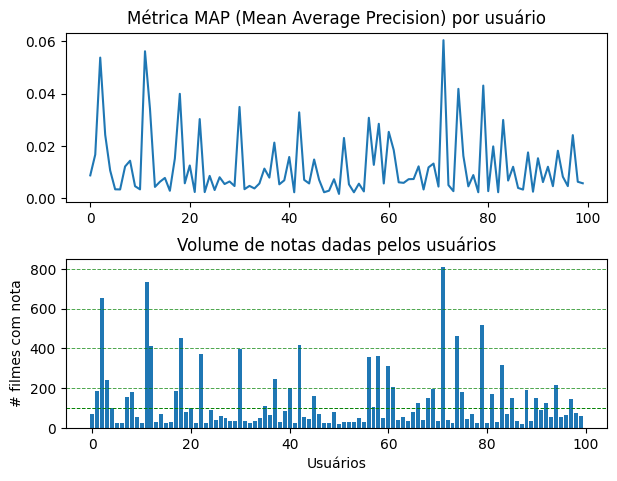

 NDCG Score: 0.3640995774251147 



In [51]:
medir_resultados(metrica_SVD_map, matriz_SVD_score, matriz_true_SVD_real, matriz_assistidos)

Comparando com TF-IDF na mesma quantidade de usuários (tempo de execução: 5m 52.7)

In [52]:
matriz_true_bin, matriz_score, metrica_map, matriz_assistidos, matriz_true_real = calcular_map(100)

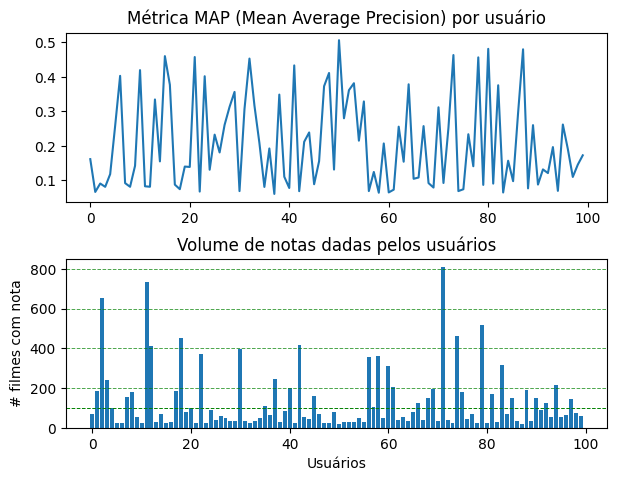

 NDCG Score: 0.6615093123257965 



In [53]:
medir_resultados(metrica_map, matriz_score, matriz_true_real, matriz_assistidos)